# Analysis

Same as the *_ap.ipynb file but with PZ filter. Similar analysis applies to this file.

Evidence is within errorbars of the AP model.

In [2]:
%run init.ipy

from lib import constants
from lib import klatt
from lib import util
from inv import model
from inv import process

2024-01-08 01:06:41.909184: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-01-08 01:06:42.735018: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-01-08 01:06:42.735121: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-01-08 01:06:42.735149: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed proper

In [3]:
path = __datadir__("OPENGLOT/RepositoryI/Vowel_O/O_normal_200Hz.wav")

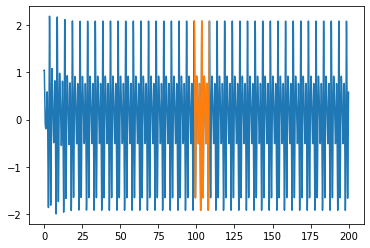

In [4]:
from scipy.io import wavfile
fs, rawdata = wavfile.read(path)

data = process.process_data(rawdata, fs, max_NP=3)

plot(data['fullt'], data['fulld'])
plot(data['t'], data['d'])

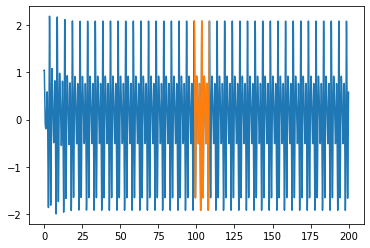

In [5]:
data = process.process_data(rawdata, fs, max_NP=3)

plot(data['fullt'], data['fulld'])
plot(data['t'], data['d'])


(array([ 98.6, 103.6, 108.6]),
 array([[          nan,           nan,           nan],
        [ 585.08020774, 2364.10460151, 2958.49149314],
        [ 585.07962237, 2364.10900539, 2958.51707931]]))

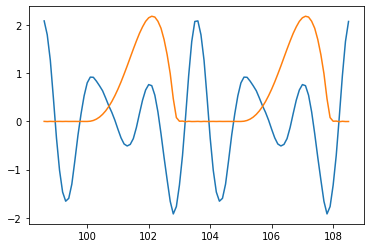

In [6]:
plot(data['t'], data['d'])
plot(data['t'], data['aux'])

data['pulse_estimate'], data['F_estimate']

[Memory]9.3s, 0.2min    : Loading get_aplawd_training_pairs_subset...


[Memory]26.9s, 0.4min   : Loading run_nested...
[Memory]29.2s, 0.5min   : Loading run_nested...
[Memory]31.5s, 0.5min   : Loading run_nested...
[Memory]34.0s, 0.6min   : Loading run_nested...
NP = 3
Number of data points: 100
Number of model dimensions: 50


({'kernel_name': 'Matern32Kernel',
  'kernel_M': 128,
  'use_oq': True,
  'impose_null_integral': True},
 PoleZeroFilter(3))

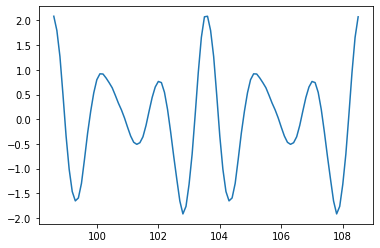

In [7]:
from inv import model
from inv import process
from vtr.prior import filter
import jax

source_config = dict(
    kernel_name = "Matern32Kernel",
    kernel_M = 128,
    use_oq = True,
    impose_null_integral = True
)

vtfilter = filter.PZ(3, numpy_backend=jax.numpy, scipy_backend=jax.scipy)

ftril = process.get_source_amplitudes_tril(
    data['NP'], source_config['kernel_M']
)

hyper = dict(
    meta = dict(
        noiseless_estimates = False,
        bf = constants.BOUNDARY_FACTOR,
        rho = .5, # Peak picking
        inference_method = "nested_sampling",
        inference_method_options = {}
    ),
    ftril = ftril,
    data = data,
    source = source_config,
    filter = vtfilter
)

plot(hyper['data']['t'], hyper['data']['d'])
print("NP =", hyper['data']['NP'])
print("Number of data points:", len(hyper['data']['d']))
print("Number of model dimensions:", model.ndim(hyper))

display(klatt.play(hyper['data']['t'], hyper['data']['d']))

hyper['source'], hyper['filter']

In [8]:
prior = model.theta_trajectory_prior(hyper)
theta = prior.sample(seed=jaxkey())
theta, prior.log_prob(theta)

[Memory]35.1s, 0.6min   : Loading get_aplawd_training_pairs_subset...
[Memory]36.0s, 0.6min   : Loading posterior_of_fitted_lf_values...
[Memory]36.2s, 0.6min   : Loading run_nested...
[Memory]36.3s, 0.6min   : Loading get_aplawd_training_pairs_subset...
[Memory]41.7s, 0.7min   : Loading posterior_of_fitted_TFB_values...
[Memory]41.9s, 0.7min   : Loading run_nested...
[Memory]42.0s, 0.7min   : Loading get_vtrformants_training_data...
[Memory]51.7s, 0.9min   : Loading run_nested...
[Memory]53.0s, 0.9min   : Loading run_nested...
[Memory]54.2s, 0.9min   : Loading run_nested...
[Memory]55.5s, 0.9min   : Loading run_nested...
[Memory]55.6s, 0.9min   : Loading get_vtrformants_training_data...


({'noise_sigma': DeviceArray(0.22240914, dtype=float64),
  'delta': DeviceArray(0.13023771, dtype=float64),
  'source': DeviceArray([[11.59852106,  1.38144908,  4.51001393,  0.99637454],
               [12.99089192,  1.46822193,  4.91510827,  0.99727562],
               [12.49115259,  1.38495568,  4.90309322,  0.99689995]],            dtype=float64),
  'filter': DeviceArray([[ 507.2630642 , 2532.12009502, 3131.64225318,   55.01082936,
                  95.69984536,   95.24738283],
               [ 508.53145958, 2656.0196873 , 3162.2560275 ,   51.99638942,
                  99.92232436,   97.9159185 ],
               [ 504.20628051, 2730.05021357, 3167.5811167 ,   50.1516561 ,
                 106.4189737 ,   98.07720654]], dtype=float64),
  'g': DeviceArray([[ 1.3104238 ,  0.83934834, -2.64421801,  0.30643841,
                -0.99545075, -1.69459728],
               [-1.62975193,  0.81006364, -0.56533713, -0.88086364,
                -0.93544852,  0.31575183],
               [-0.46999

Show the possible model functions $f(t;\theta)$ for a sampled $\theta$. We need to find a $\theta$ for which **most** -- not just a few -- of these samples are close to the data. **This is Bayesian regularization in action.**

We can see that the general amplitude magnitude is reasonable, although for larger $K$ for PZ and $N_P$ it may take more samples to hit O(1) range. This is because of interpitch-period correlations and the heavier tails of the energy distribution of the PZ model.

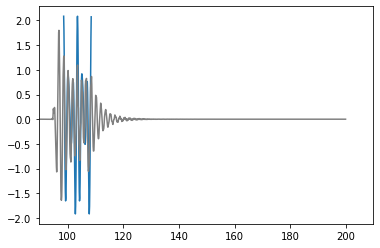

In [9]:
theta = prior.sample(seed=jaxkey())
noise_sigma, delta, theta_source, theta_filter = model.unpack_theta(theta, hyper)

hyper2 = process.hyper_fullt(hyper)

R = model.full_kernelmatrix_root(
    delta, theta_source, theta_filter, hyper2, convolve=True
)

plot(hyper['data']['t'], hyper['data']['d'])

nsamp = 1
for _ in range(nsamp):
    w = model.randf(hyper)
    f = R @ w
    plot(hyper['data']['fullt'], f, color='grey', alpha=1/sqrt(nsamp))

def setxlim(f, margin=0.05):
    ts = hyper['data']['fullt'][f != 0.]
    xlim(ts[0]*(1-margin), ts[-1]*(1+margin))

setxlim(f)

klatt.play(hyper['data']['t'], f)

We can see the correlations in the $f$ amplitudes well.

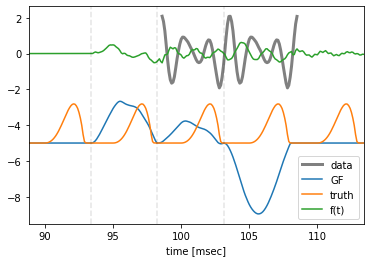

In [10]:
theta = prior.sample(seed=jaxkey())
noise_sigma, delta, theta_source, theta_filter = model.unpack_theta(theta, hyper)
offset = model.get_offset(delta, theta_source, hyper)

hyper2 = process.hyper_fullt(hyper)

R = model.full_kernelmatrix_root(
    delta, theta_source, theta_filter, hyper2, convolve=True, correlatef=False
)

R_gfd = model.full_kernelmatrix_root(
    delta, theta_source, theta_filter, hyper2, 
    convolve=False, integrate=True, correlatef=False
)

w = model.randf(hyper)

plot(hyper['data']['t'], hyper['data']['d'], color="grey", label="data", lw=3)

plot(hyper['data']['fullt'], R_gfd @ w - 5, label="GF")
plot(hyper['data']['fullt'], hyper['data']['fullaux'] - 5, label="truth")

plot(hyper['data']['fullt'], R @ w, label="f(t)")
for tp in offset: axvline(tp, ls="--", color="black", alpha=.1)
xlabel("time [msec]")
setxlim(R_gfd @ w)
legend();

## Test NS algorithm

In [11]:
import dynesty
import scipy
from inv import model

theta_bijector = model.theta_trajectory_bijector(hyper)
    
@jax.jit
def loglike(w):
    theta = theta_bijector.forward(w)
    logl = model.full_likelihood(theta, hyper)
    return logl

ptform = scipy.special.ndtri

ndim = model.ndim(hyper)
ndim

[Memory]73.7s, 1.2min   : Loading posterior_of_fitted_lf_values...
[Memory]73.7s, 1.2min   : Loading run_nested...
[Memory]73.8s, 1.2min   : Loading posterior_of_fitted_TFB_values...
[Memory]73.8s, 1.2min   : Loading run_nested...


50

In [12]:
w = ptform(rand(ndim))
loglike(w), theta_bijector.forward(w)

(DeviceArray(-773.09342957, dtype=float64),
 {'noise_sigma': DeviceArray(0.18864599, dtype=float64),
  'delta': DeviceArray(0.41688297, dtype=float64),
  'source': DeviceArray([[4.7502028 , 1.10406256, 5.16108343, 0.9971149 ],
               [4.50799899, 1.06476532, 5.48115995, 0.9970267 ],
               [5.00582321, 1.19375394, 5.33049825, 0.99729201]],            dtype=float64),
  'filter': DeviceArray([[ 382.80809468, 1799.02577876, 2586.57591685,  145.90657694,
                  81.9917105 ,  166.04377344],
               [ 391.70315333, 1791.81335556, 2563.74640447,  129.39784993,
                  91.2075713 ,  141.210645  ],
               [ 401.15823454, 1817.33171837, 2550.47220045,  110.57064805,
                 107.45739708,  126.60451039]], dtype=float64),
  'g': DeviceArray([[ 0.74419798, -0.60812561,  0.64309388, -1.14930857,
                -0.62130303,  1.25349206],
               [-0.62199031,  1.7650865 ,  1.01140187, -2.39977477,
                -1.72178373,  1.321

In [12]:
SAMPLERARGS = {'sample': 'rslice', 'first_update': {'min_eff': 5.}}
RUNARGS = {'save_bounds': False, 'maxcall': int(1e7)}

# Could use 10% stopping criteria as in Petrosyan+ 2023
sampler = dynesty.NestedSampler(
    loglike, ptform, ndim, nlive=3*ndim, **SAMPLERARGS
)

sampler.run_nested(**RUNARGS)
results = sampler.results

156it [00:08, 11.33it/s, bound: 0 | nc: 7 | ncall: 488 | eff(%): 31.967 | loglstar:   -inf < -316.033 <    inf | logz: -321.258 +/-  0.181 | dlogz: 394.900 >  0.159]    

9186it [15:27:12,  6.06s/it, +150 | bound: 242 | nc: 1 | ncall: 2872797 | eff(%):  0.325 | loglstar:   -inf < 236.140 <    inf | logz: 176.891 +/-  0.581 | dlogz:  0.001 >  0.159]


Summary
nlive: 150
niter: 9186
ncall: 2872647
eff(%):  0.325
logz: 176.891 +/-  0.656


None

'Information (bans)'

20.874876684054907

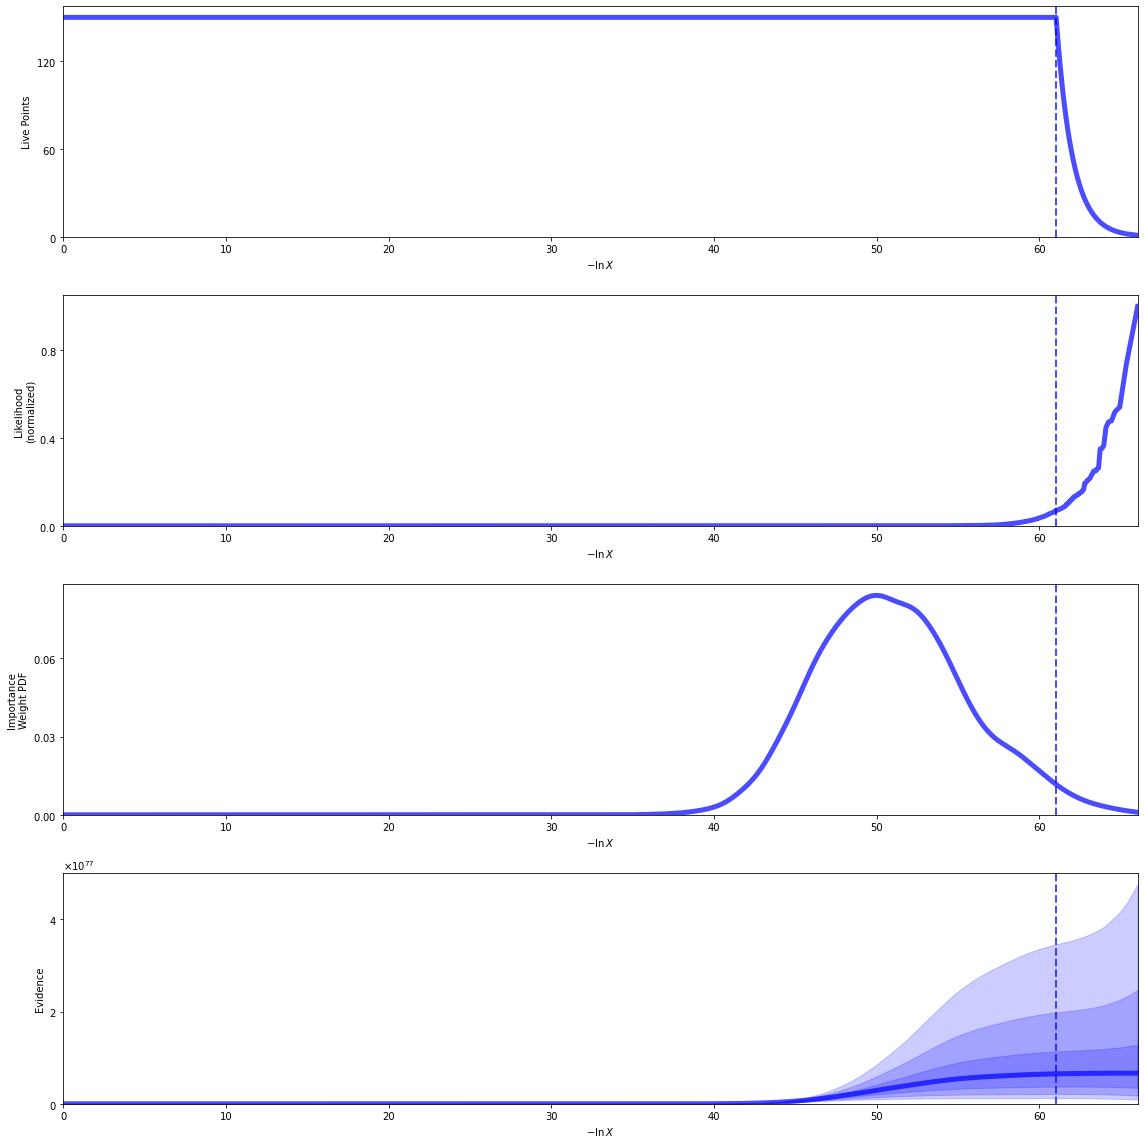

Quantiles:
$x_{1}$ [(0.025, -6.227710541016037), (0.5, -5.240782083225304), (0.975, -4.548588108879588)]
Quantiles:
$x_{2}$ [(0.025, -1.2855289922934374), (0.5, -0.6725186492666803), (0.975, -0.250854743395585)]
Quantiles:
$x_{3}$ [(0.025, -0.7826651949219536), (0.5, -0.26187155283391367), (0.975, 0.25107088660788407)]
Quantiles:
$x_{4}$ [(0.025, -2.1705075508236313), (0.5, -0.8278902044290523), (0.975, -0.1407365530363125)]
Quantiles:
$x_{5}$ [(0.025, -1.4219088554970574), (0.5, 0.01890261019571597), (0.975, 1.718892892421111)]
Quantiles:
$x_{6}$ [(0.025, -0.5773931413105685), (0.5, -0.12305287352581117), (0.975, 0.2522845990686307)]
Quantiles:
$x_{7}$ [(0.025, -1.9163944718463377), (0.5, -0.7614415605608655), (0.975, 0.09041022275288897)]
Quantiles:
$x_{8}$ [(0.025, -1.7468052978465523), (0.5, -0.7384716204183182), (0.975, 0.041721424704505176)]
Quantiles:
$x_{9}$ [(0.025, -0.8455959688337823), (0.5, 0.26569590167965423), (0.975, 1.2629122677093862)]
Quantiles:
$x_{10}$ [(0.025, -1.7

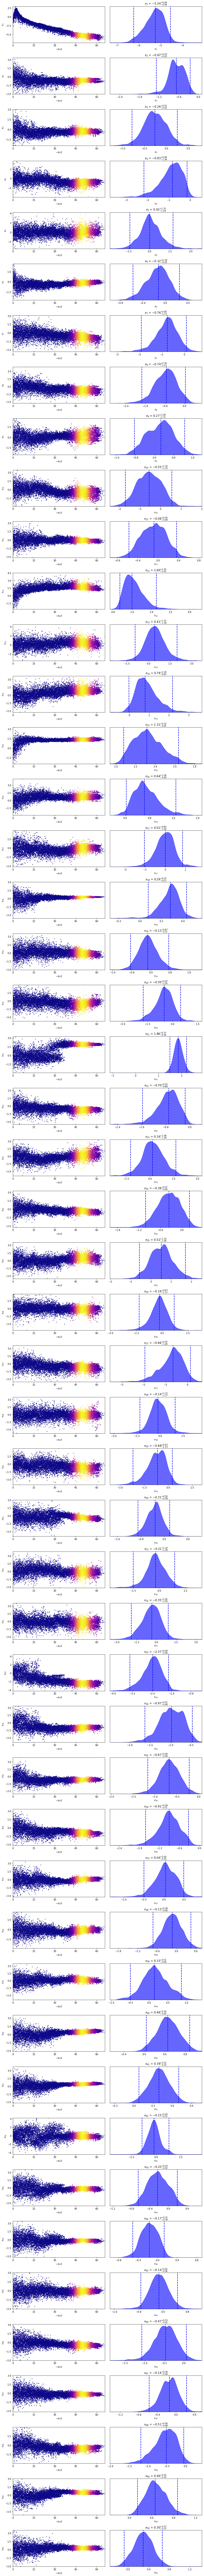

In [13]:
util.dyplot(results, runplot=True, traceplot=True, cornerplot=False)

In [13]:
@jax.jit
def lstsq(R, y, noise_power):
    D = jnp.eye(R.shape[1])
    Z = noise_power * D + R.T @ R
    L, lower = jax.scipy.linalg.cho_factor(Z, lower=True, check_finite=False)
    b = R.T @ y
    x = jax.scipy.linalg.cho_solve((L, lower), b, check_finite=False)
    return x

0	log L = 214.49209381736233	SNR [dB] = 52.29744626178892
1	log L = 217.21119360481492	SNR [dB] = 55.18556995444837
2	log L = 227.83473920787043	SNR [dB] = 56.14701265119667
3	log L = 231.26296826280225	SNR [dB] = 57.69775857710796
4	log L = 231.0092024000145	SNR [dB] = 57.7063607066501
5	log L = 228.90611747878933	SNR [dB] = 57.10048983047813
6	log L = 216.09999994434673	SNR [dB] = 56.87543145806903
7	log L = 232.9976056104004	SNR [dB] = 57.44204896311806
8	log L = 220.5314936447993	SNR [dB] = 55.17764962006645
9	log L = 227.28888293568895	SNR [dB] = 56.444945740987464
10	log L = 215.7985188444718	SNR [dB] = 52.79576292215624
11	log L = 223.8884827912771	SNR [dB] = 57.59494906504809
12	log L = 225.13614405739753	SNR [dB] = 56.73424951685982
13	log L = 222.20101494857397	SNR [dB] = 55.48717983023093
14	log L = 223.15783996985755	SNR [dB] = 54.450439545654234
15	log L = 224.12311005503886	SNR [dB] = 57.580825404529925
16	log L = 231.9872354266504	SNR [dB] = 57.68647745935536
17	log L = 

DeviceArray(0.1176825, dtype=float64)

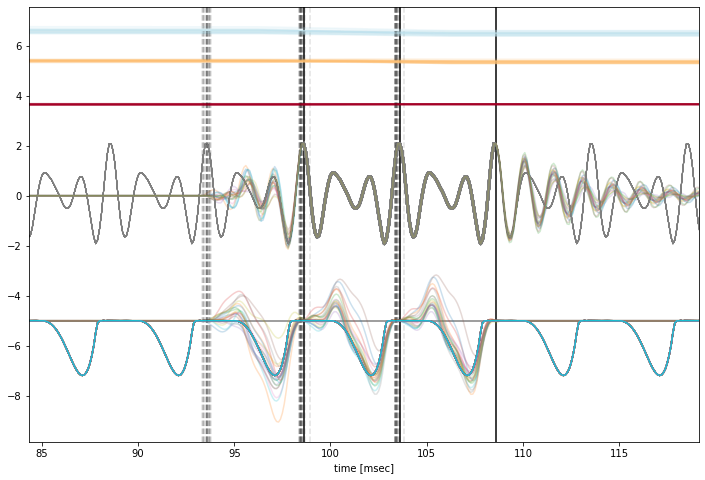

In [19]:
nsamp = 20

w_samples = util.resample_equal(results, nsamp)

figsize(12, 8)
axhline(-5, color="grey")

for pest in hyper['data']['pulse_estimate']: axvline(pest, color="black")

for i, w_sample in enumerate(w_samples):
    print(i, end='\t')
    
    theta = theta_bijector.forward(w_sample)
    print("log L =", model.full_likelihood(theta, hyper), end='\t')

    noise_sigma, delta, theta_source, theta_filter = model.unpack_theta(theta, hyper)
    offset = model.get_offset(delta, theta_source, hyper)
    print("SNR [dB] =", -20*log10(noise_sigma))

    R = model.full_kernelmatrix_root(
        delta, theta_source, theta_filter, hyper, convolve=True
    )

    f_mean = lstsq(R, hyper['data']['d'], noise_sigma**2)

    hyper2 = process.hyper_fullt(hyper)
    R2 = model.full_kernelmatrix_root(
        delta, theta_source, theta_filter, hyper2, convolve=True
    )

    R_gfd2 = model.full_kernelmatrix_root(
        delta, theta_source, theta_filter, hyper2, convolve=False, integrate=True
    )

    ft = R2 @ f_mean
    gf = R_gfd2 @ f_mean

    
    alpha = 1/sqrt(nsamp)
    plot(hyper['data']['fullt'], hyper['data']['fulld'], color="grey", label="data", lw=1)
    plot(hyper['data']['t'], hyper['data']['d'], color="grey", label="data", lw=3)
    plot(hyper['data']['fullt'], gf - 5, label="GF", alpha=alpha)
    plot(hyper['data']['fullt'], ft, label="f(t)", alpha=alpha)
    plot(hyper['data']['fullt'], -hyper['data']['fullaux'] - 5, label="truth")
    for tp in offset: axvline(tp, ls="--", color="black", alpha=.5*alpha)
    xlabel("time [msec]")
    setxlim(gf, .1)
    #legend()
    
    for k, x in enumerate(theta_filter['x'].T):
        x_interp = np.interp(
            hyper['data']['fullt'], offset + theta_source['T']/2, x
        )
        plot(
            hyper['data']['fullt'], 3 + x_interp/1000,
            alpha=alpha, color=plt.cm.RdYlBu(k/hyper['filter'].K)
        )

    #display(klatt.play(hyper['data']['t'], hyper['data']['d']))
    #display(klatt.play(hyper['data']['t'], ft))

delta

In [16]:
model.unpack_theta(theta, hyper)

(DeviceArray(0.00168065, dtype=float64),
 DeviceArray(0.01575234, dtype=float64),
 {'Oq': DeviceArray([0.99609042, 0.99689022, 0.99699983], dtype=float64),
  'T': DeviceArray([5.27662605, 4.96108279, 5.00824676], dtype=float64),
  'r': DeviceArray([0.27632165, 0.24759064, 0.28459364], dtype=float64),
  'var_sigma': DeviceArray([2.01125178, 1.84467898, 2.37437331], dtype=float64)},
 {'g': DeviceArray([[-3.21261497, -2.07237206, -0.06242729, -0.05323783,
                 0.22575272, -0.78830951],
               [-2.64773576, -0.76694388,  0.82719176, -0.44658343,
                -0.67943507,  0.28204875],
               [-2.52942883, -0.96092318,  0.77573045, -0.38074222,
                -0.7037873 ,  0.49446144]], dtype=float64),
  'x': DeviceArray([[ 619.50880726, 2401.02613588, 3674.65721391],
               [ 643.65764088, 2370.55495977, 3603.98321726],
               [ 663.42138082, 2307.87884123, 3537.27478101]],            dtype=float64),
  'y': DeviceArray([[ 79.01654818,  47.230

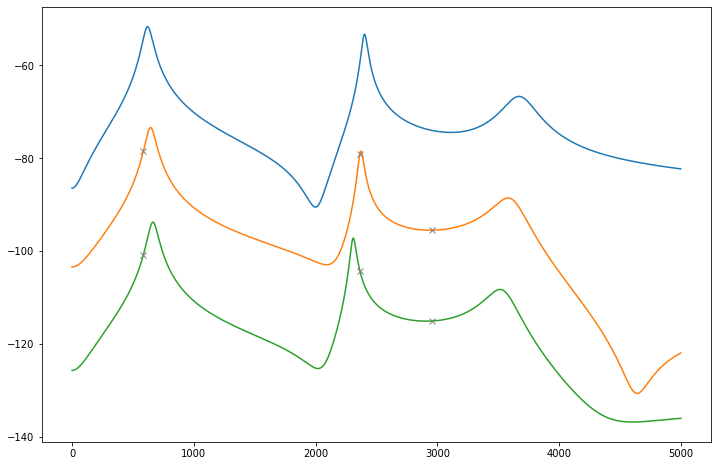

In [17]:
f = constants.spectrum_frequencies()

powers = jax.vmap(hyper['filter'].transfer_function_power_dB, (None, 0, 0, 0))(
    f, theta_filter['x'], theta_filter['y'], theta_filter['g']
)

for i, power in enumerate(powers):
    plot(f, power - i*20)
    
    F = hyper['data']['F_estimate'][i,:]
    estim = np.interp(F, f, power - i*20)
    plot(F, estim, 'x', color="grey")

# Given the true formant estimates, not Praat's

In [14]:
F_true = np.vstack([[570., 840., 2410.]]*3)

F_true, data['F_estimate']

(array([[ 570.,  840., 2410.],
        [ 570.,  840., 2410.],
        [ 570.,  840., 2410.]]),
 array([[          nan,           nan,           nan],
        [ 585.08020774, 2364.10460151, 2958.49149314],
        [ 585.07962237, 2364.10900539, 2958.51707931]]))

In [15]:
# Impose truth formant estimates
new_data = data.copy()
new_data['F_estimate'] = F_true

new_hyper = process.hyper_variation(hyper, data=new_data)

In [16]:
theta_bijector = model.theta_trajectory_bijector(new_hyper)
    
@jax.jit
def loglike(w):
    theta = theta_bijector.forward(w)
    logl = model.full_likelihood(theta, new_hyper)
    return logl

ptform = scipy.special.ndtri

ndim = model.ndim(new_hyper)
ndim

[Memory]77.5s, 1.3min   : Loading posterior_of_fitted_lf_values...
[Memory]77.6s, 1.3min   : Loading run_nested...
[Memory]77.7s, 1.3min   : Loading posterior_of_fitted_TFB_values...
[Memory]77.7s, 1.3min   : Loading run_nested...


50

In [17]:
xs = []

for i in range(100):
    w = ptform(rand(ndim))
    theta = theta_bijector.forward(w)
    xs.append(theta['filter'][0,:2])

xs = np.array(xs)
xs

array([[ 456.34052069,  898.60124672],
       [ 602.86001795,  945.23197576],
       [ 648.89708443, 1277.80277322],
       [ 544.0709037 ,  846.33034068],
       [ 496.93473854, 1356.81375415],
       [ 597.42001918,  922.91235982],
       [ 604.27069817,  780.97699491],
       [ 574.8099506 , 1118.89122745],
       [ 533.26695838, 1014.23221066],
       [ 611.20569018,  967.84547024],
       [ 628.54648842, 1059.85681153],
       [ 527.04414818,  631.82544224],
       [ 601.62457517,  984.91715813],
       [ 585.47217958,  850.61293995],
       [ 455.31510559,  865.46907873],
       [ 467.46573734,  822.53966015],
       [ 671.89099899, 1277.71714801],
       [ 459.98816057,  863.20799858],
       [ 642.94643765,  829.55168925],
       [ 408.44699502,  731.91793866],
       [ 731.53584612, 1122.28273133],
       [ 538.80966982,  947.86909053],
       [ 498.59192765,  590.34990949],
       [ 552.58996005,  859.83786896],
       [ 558.45582467,  664.51793859],
       [ 542.91327098, 11

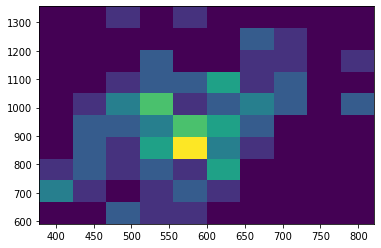

In [18]:
hist2d(xs[:,0], xs[:,1]);

In [ ]:
SAMPLERARGS = {'sample': 'rslice', 'first_update': {'min_eff': 5.}}
RUNARGS = {'save_bounds': False, 'maxcall': int(1e7)}

# Could use 10% stopping criteria as in Petrosyan+ 2023
sampler = dynesty.NestedSampler(
    loglike, ptform, ndim, nlive=3*ndim, **SAMPLERARGS
)

sampler.run_nested(**RUNARGS)
results = sampler.results

7224it [11:44:42,  5.85s/it, +150 | bound: 152 | nc: 1 | ncall: 2105332 | eff(%):  0.350 | loglstar:   -inf < 213.406 <    inf | logz: 167.208 +/-  0.513 | dlogz:  0.001 >  0.159]


Summary
nlive: 150
niter: 7224
ncall: 2105182
eff(%):  0.350
logz: 167.208 +/-  0.595


None

'Information (bans)'

15.938076860207246

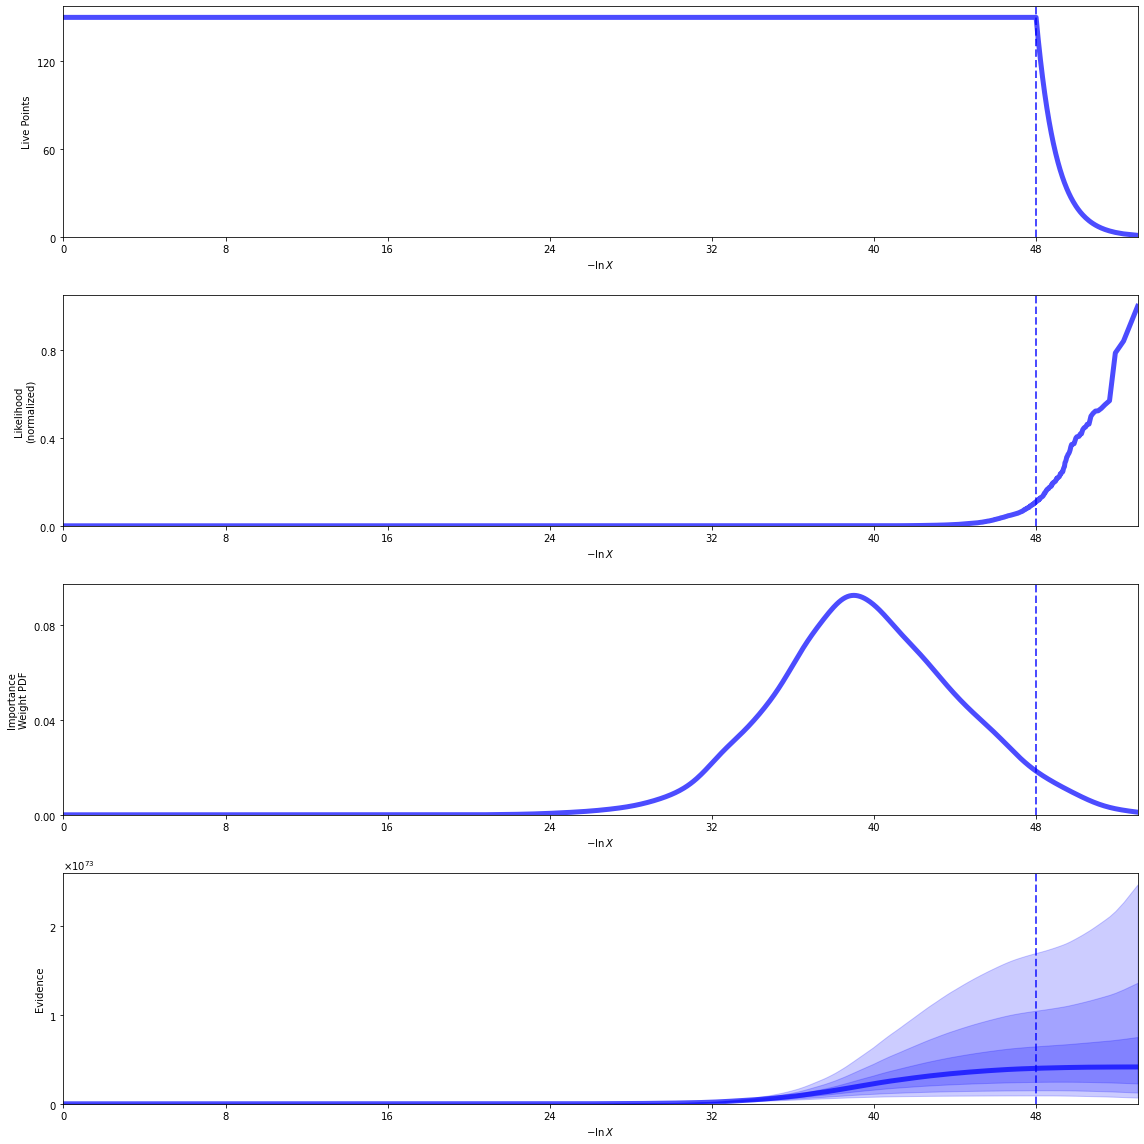

Quantiles:
$x_{1}$ [(0.025, -5.16681131079857), (0.5, -4.177148729098617), (0.975, -3.193305244116541)]
Quantiles:
$x_{2}$ [(0.025, -1.7530768443143843), (0.5, -0.6708441687792118), (0.975, -0.28711786097856845)]
Quantiles:
$x_{3}$ [(0.025, -1.4843646515252265), (0.5, -0.6183031743308933), (0.975, -0.2417120065652909)]
Quantiles:
$x_{4}$ [(0.025, -0.4093183024324049), (0.5, 0.1409574282942623), (0.975, 1.4892516585545093)]
Quantiles:
$x_{5}$ [(0.025, -1.315260288325655), (0.5, -0.5755945661430298), (0.975, 0.08814901389408884)]
Quantiles:
$x_{6}$ [(0.025, -0.4341956903567163), (0.5, -0.11668990807468413), (0.975, 0.26661157018224113)]
Quantiles:
$x_{7}$ [(0.025, -1.9521722641540147), (0.5, -1.099187652009088), (0.975, 0.08328935600869175)]
Quantiles:
$x_{8}$ [(0.025, 0.6740864995477943), (0.5, 1.1438312631803809), (0.975, 2.3156977563077197)]
Quantiles:
$x_{9}$ [(0.025, -0.3455291691045218), (0.5, 0.23945997819509396), (0.975, 0.697337062416651)]
Quantiles:
$x_{10}$ [(0.025, -0.9560178

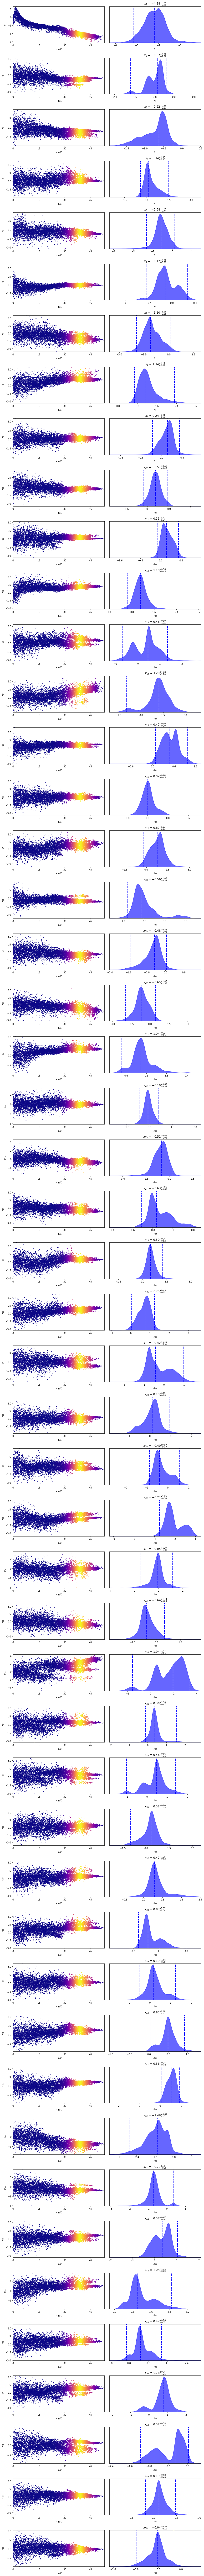

In [20]:
util.dyplot(results, runplot=True, traceplot=True, cornerplot=False)

0	log L = 204.43815401896876	SNR [dB] = 51.465625727134324
1	log L = 199.41303287576181	SNR [dB] = 54.025312983333535
2	log L = 206.98527948188217	SNR [dB] = 51.364152685699665
3	log L = 201.0006066755255	SNR [dB] = 54.7122231782101
4	log L = 195.97110931981115	SNR [dB] = 49.85723872195415
5	log L = 209.2352575056512	SNR [dB] = 53.095776119599336
6	log L = 202.66833456752244	SNR [dB] = 54.699775800824675
7	log L = 206.07542645558578	SNR [dB] = 52.24305590668532
8	log L = 206.39446440237492	SNR [dB] = 53.61408548115296
9	log L = 206.44980497854306	SNR [dB] = 55.54734090578714


DeviceArray(0.03736383, dtype=float64)

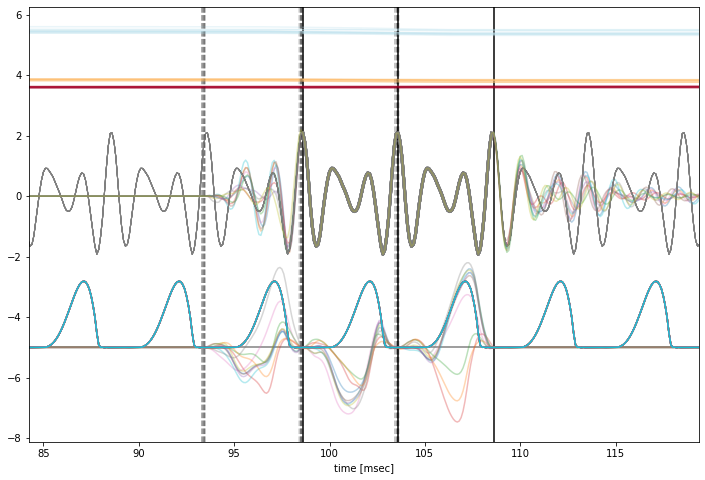

In [24]:
nsamp = 10

w_samples = util.resample_equal(results, nsamp)

figsize(12, 8)
axhline(-5, color="grey")

for pest in new_hyper['data']['pulse_estimate']: axvline(pest, color="black")

for i, w_sample in enumerate(w_samples):
    print(i, end='\t')
    
    theta = theta_bijector.forward(w_sample)
    print("log L =", model.full_likelihood(theta, new_hyper), end='\t')

    noise_sigma, delta, theta_source, theta_filter = model.unpack_theta(theta, new_hyper)
    offset = model.get_offset(delta, theta_source, new_hyper)
    print("SNR [dB] =", -20*log10(noise_sigma))

    R = model.full_kernelmatrix_root(
        delta, theta_source, theta_filter, new_hyper, convolve=True
    )

    f_mean = lstsq(R, new_hyper['data']['d'], noise_sigma**2)

    new_hyper2 = process.hyper_fullt(new_hyper)
    R2 = model.full_kernelmatrix_root(
        delta, theta_source, theta_filter, new_hyper2, convolve=True
    )

    R_gfd2 = model.full_kernelmatrix_root(
        delta, theta_source, theta_filter, new_hyper2, convolve=False, integrate=True
    )

    ft = R2 @ f_mean
    gf = R_gfd2 @ f_mean

    
    alpha = 1/sqrt(nsamp)
    plot(new_hyper['data']['fullt'], new_hyper['data']['fulld'], color="grey", label="data", lw=1)
    plot(new_hyper['data']['t'], new_hyper['data']['d'], color="grey", label="data", lw=3)
    plot(new_hyper['data']['fullt'], gf - 5, label="GF", alpha=alpha)
    plot(new_hyper['data']['fullt'], ft, label="f(t)", alpha=alpha)
    plot(new_hyper['data']['fullt'], new_hyper['data']['fullaux'] - 5, label="truth")
    for tp in offset: axvline(tp, ls="--", color="black", alpha=.5*alpha)
    xlabel("time [msec]")
    setxlim(gf, .1)
    #legend()
    
    for k, x in enumerate(theta_filter['x'].T):
        x_interp = np.interp(
            new_hyper['data']['fullt'], offset + theta_source['T']/2, x
        )
        plot(
            new_hyper['data']['fullt'], 3 + x_interp/1000,
            alpha=alpha, color=plt.cm.RdYlBu(k/new_hyper['filter'].K)
        )

    #display(klatt.play(hyper['data']['t'], hyper['data']['d']))
    #display(klatt.play(hyper['data']['t'], ft))

delta

Note that the GCI estimates of BNGIF are quasi perfect, as opposed to Praat's pulse estimates.

In [25]:
model.unpack_theta(theta, new_hyper)

(DeviceArray(0.00166968, dtype=float64),
 DeviceArray(0.03736383, dtype=float64),
 {'Oq': DeviceArray([0.98705627, 0.98447748, 0.99201528], dtype=float64),
  'T': DeviceArray([5.09870003, 5.02524787, 5.00510392], dtype=float64),
  'r': DeviceArray([0.2315398 , 0.21208768, 0.22123751], dtype=float64),
  'var_sigma': DeviceArray([1.7723497 , 1.79324407, 1.64164554], dtype=float64)},
 {'g': DeviceArray([[ 2.67858319,  1.20570353, -0.55823945, -1.61040558,
                 1.24385956,  0.71453641],
               [ 1.64801852,  1.02934586,  1.29052097, -1.74270696,
                 1.3899543 ,  0.50608693],
               [ 2.01130727,  1.80987076,  1.24675368, -0.60133458,
                 1.86718261,  0.59962081]], dtype=float64),
  'x': DeviceArray([[ 596.22151458,  831.14588262, 2456.43920639],
               [ 591.73612816,  797.36330303, 2418.5062052 ],
               [ 597.19460561,  769.75633535, 2376.62460495]],            dtype=float64),
  'y': DeviceArray([[ 90.44559869,  65.284

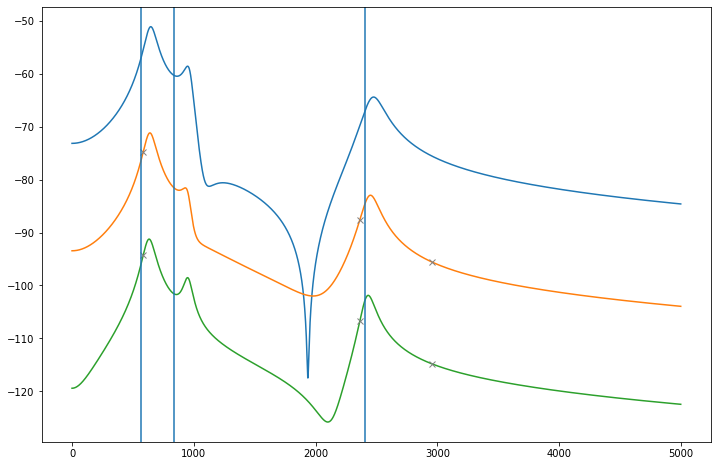

In [23]:
f = constants.spectrum_frequencies()

powers = jax.vmap(new_hyper['filter'].transfer_function_power_dB, (None, 0, 0, 0))(
    f, theta_filter['x'], theta_filter['y'], theta_filter['g']
)

for i, power in enumerate(powers):
    plot(f, power - i*20)
    
    F = hyper['data']['F_estimate'][i,:]
    estim = np.interp(F, f, power - i*20)
    plot(F, estim, 'x', color="grey")

for F in F_true[0,:]:
    axvline(F)